# Sensor shape optimization workflow

In this example we will show how to use MaMMoS for shape optimization of a magnetic sensor element. To show the versatility of the mammos software we will perform the micromagnetic simulations with the `ubermag` micromagnetic package.

In this workflow we will try to optimize the region of the hysteresis loop over which M vs H has a linear reponse. In order to do this we will first obtain micromagnetic parameters, perform micromagnetic simulations, and then analyze the loop.

This is followed by using Baysian optimization to maximize the linear region.

In [1]:
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd

# Ubermag imports
import micromagneticdata as md
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

# MaMMoS imports
import mammos_analysis
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Temperature-dependent magnetization data from spindynamics database lookup

In order to get micromagnetic parameters, spin dynamics calculation database to load data for the temperature-dependent magnetization.

In [3]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization("Nd2Fe14B")  # TODO: change material

We can visualize the pre-computed data using `.plot`.

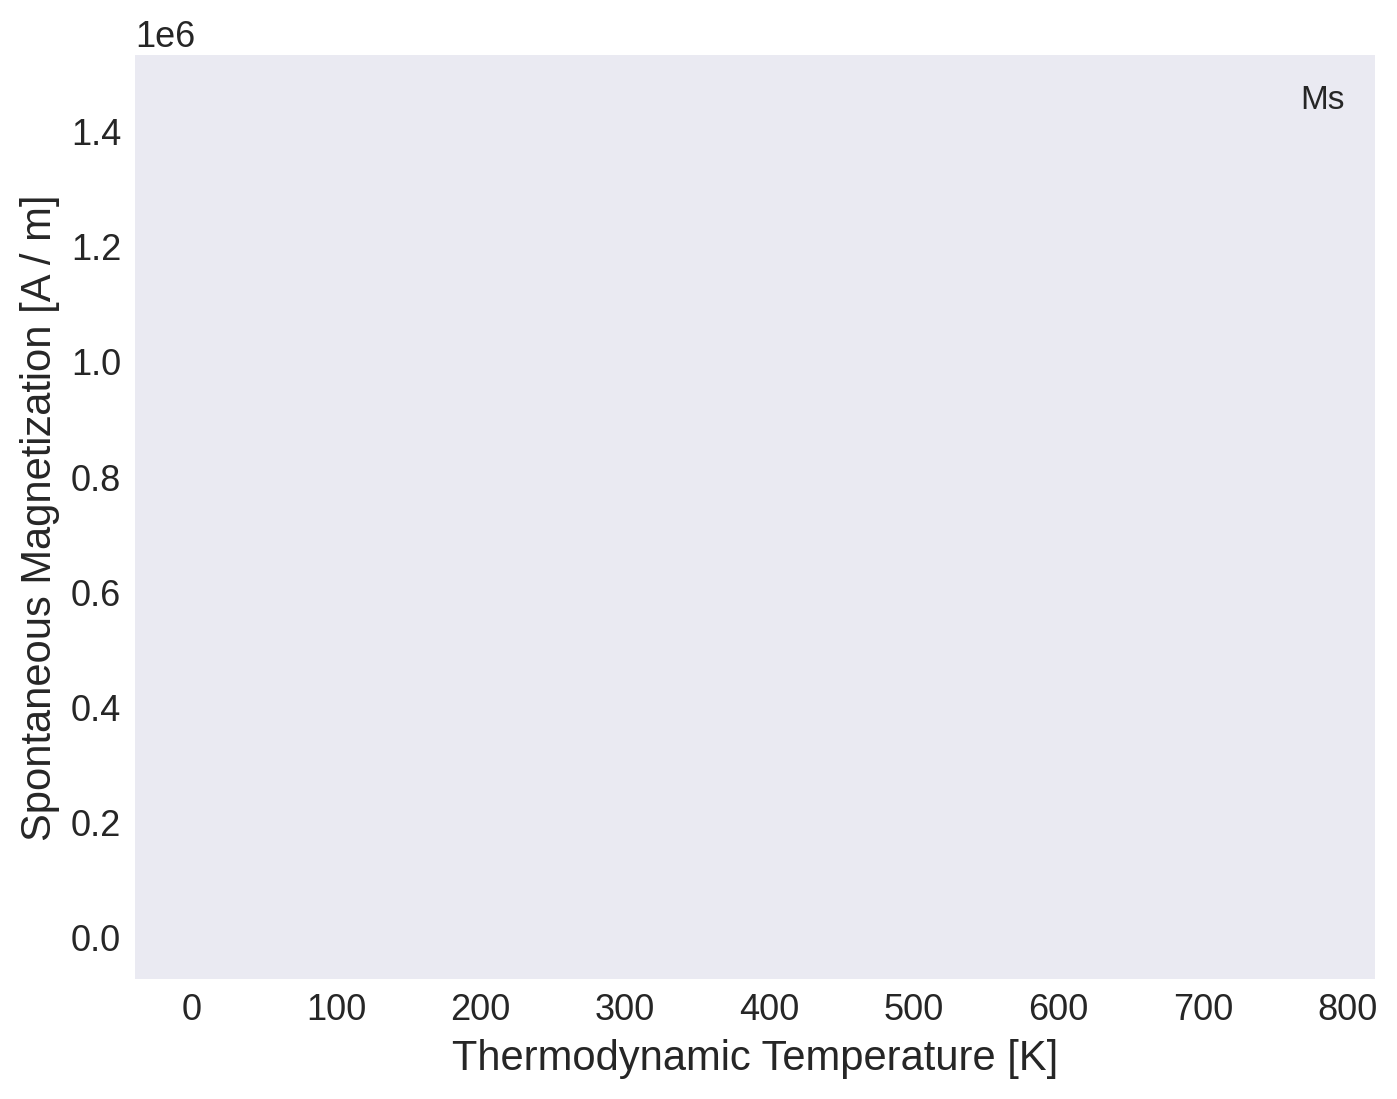

In [4]:
results_spindynamics.plot();  # TODO: Why is this not showing any points?

We can access `T` and `Ms` and get `mammos_entities.Entity` objects:

In [5]:
results_spindynamics.T

ThermodynamicTemperature(value=[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.
 630.         690.         720.         750.         780.        ], unit=K)

In [6]:
results_spindynamics.Ms

SpontaneousMagnetization(value=[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705
       0.               0.               0.               0.
       0.        ], unit=A / m)

## Calculate micromagnetic intrinsic properties using Kuz’min formula

We use Kuzmin equations to compute Ms(T) and A(T).

In [7]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
)

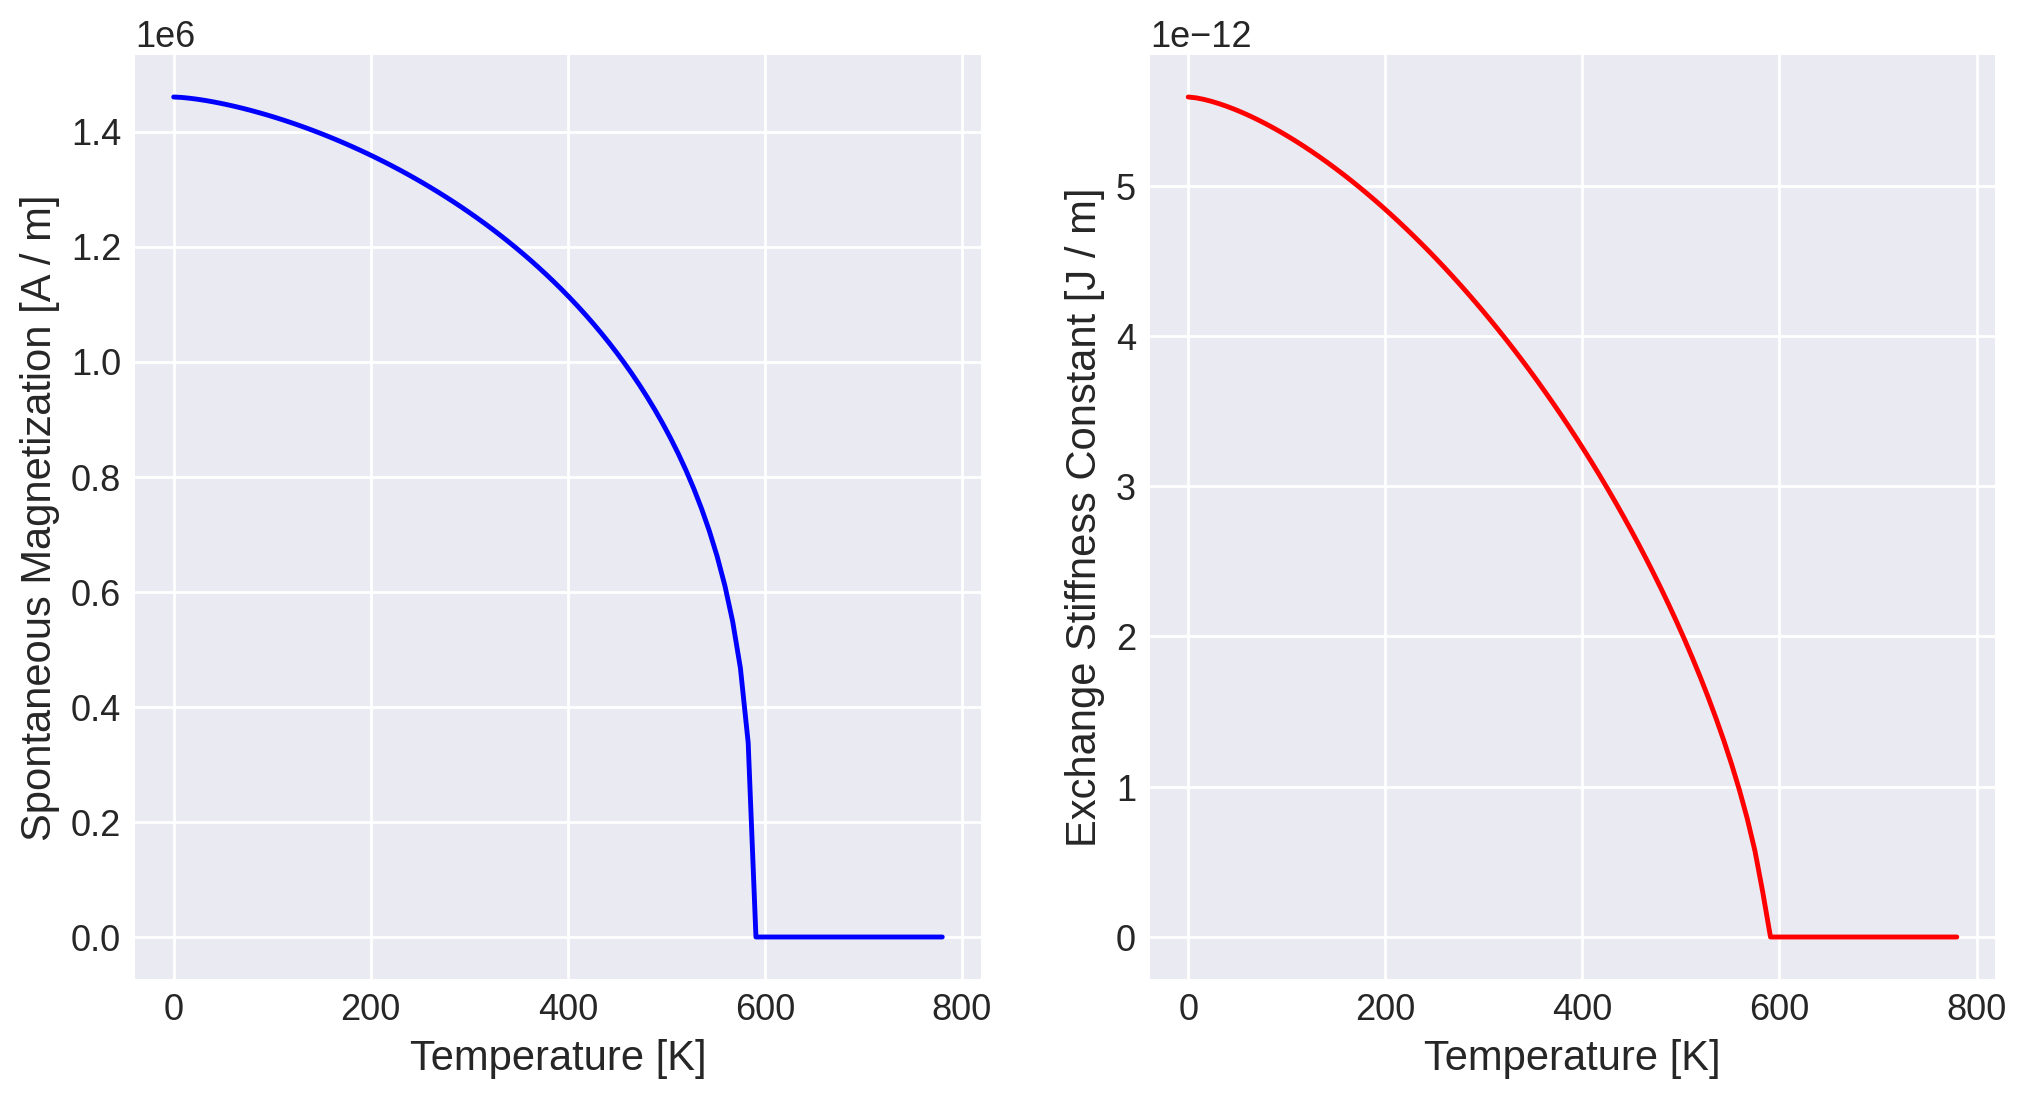

In [8]:
kuzmin_result.plot();

# Setting up the micromagnetic simulation
Run the micromagnetic simulation with parameters at 300 K.

In [9]:
T = 300 #me.T(300, unit="K")

Define the energy equation of the system.

In [10]:
system = mm.System(name="sensor")
A = me.A(11e-12)  # kuzmin_result.A(T) TODO: change when material is updated
Ms = me.Ms(0.84e6)  # kuzmin_result.Ms(T) TODO: change when material is updated
system.energy = mm.Exchange(A=A.value) + mm.Demag() + mm.Zeeman(H=(0,0,0))

Initialize the magnetization.

We will constrain the shape of our sensor to be a diamond (rhombus) with the diagonals of length $s_x$ and $s_y$ along the $x$ and $y$ directions respectively and with thickness $t$.

Here we create a $100\times 100\times 5$ nm region in which we create our diamond.

See Ubermag for more details. TODO: add links and better explanation

In [11]:
L = 100e-9
t = 5e-9
region = df.Region(p1=(-L/2, -L/2, -t/2), p2=(L/2, L/2, t/2))
mesh = df.Mesh(region=region, n=(40, 40, 1))

def in_diamond(position, sx, sy):
    x, y, _ = position
    if 2*abs(x) / sx + 2*abs(y) / sy <= 1:
        return Ms.value
    else:
        return 0

system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, 40e-9, 30e-9), valid="norm")

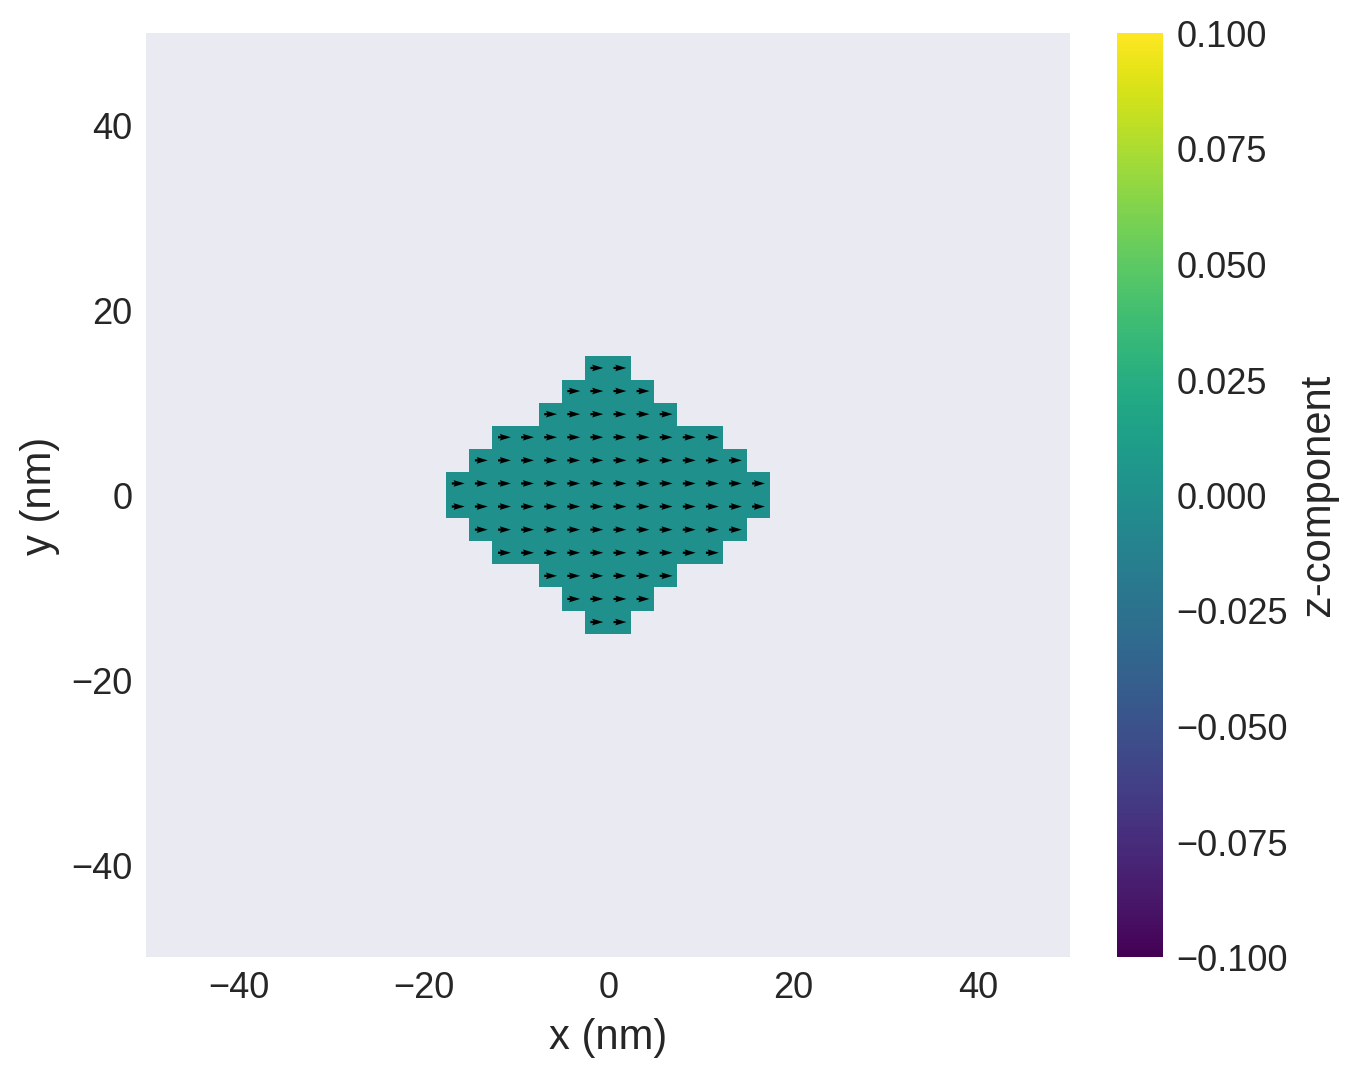

In [12]:
system.m.sel('z').mpl()

Run a hystersis loop from 300 to 0 mT in the y direction 

In [ ]:
Hmin = (0, 0, 0)
Hmax = ((0.1, 500, 0)*u.mT).to(u.A/u.m) # Convert to A/m for Ubermag compatibility
n = 101

hd = mc.HysteresisDriver()
hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]])

Running OOMMF (ExeOOMMFRunner)[2025/05/31 16:43]... (8.3 s)


Extract entitles from the results of our field sweep

In [14]:
H_y = me.H(system.table.data["By_hysteresis"].values*u.Unit(system.table.units["By_hysteresis"]).to(u.A/u.m))
M_y = system.table.data["my"].values*Ms

## Linear segment
Use `mammos-analysis` to find the properties of the linearized hysteresis loop.

In [15]:
results_linear = mammos_analysis.hysteresis.find_linear_segment(H_y, M_y, margin=0.05*Ms, min_points=5)

In [16]:
results_linear.Hmax

ExternalMagneticField(value=33422.538012880366, unit=A / m)

In [17]:
results_linear.Mr

Remanence(value=28466.28650205641, unit=A / m)

In [18]:
results_linear.gradient

<Quantity 24.38349475>

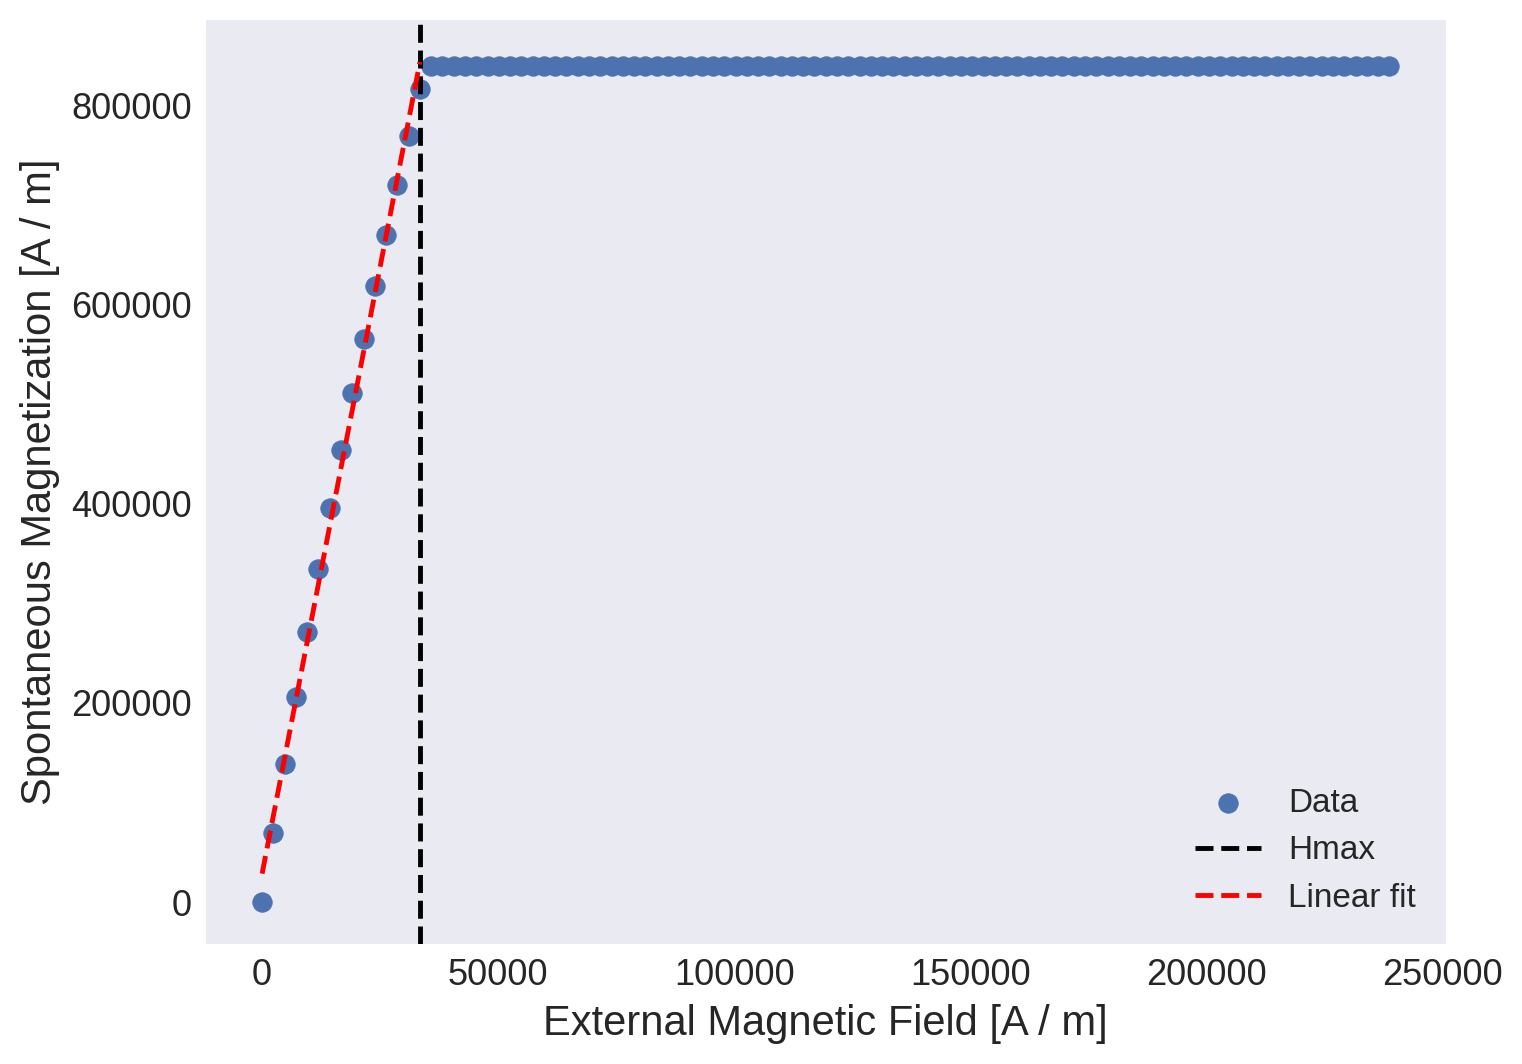

In [19]:
results_linear.plot();

## Optimization

Here we will use Bayesian optimization to maximize the size length of the liner region of the hysteresis loop by optimizing the lengths of the diagnonals of the diamond.

In [20]:
from bayes_opt import BayesianOptimization

Define the objective function to maximize the size of the linear region.

In [ ]:
def objective(sx, sy):
    system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, sx, sy), valid="norm")  # Change shape
    hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]], verbose=0)  # Field sweep
    H_y = me.H(system.table.data["By_hysteresis"].values*u.Unit(system.table.units["By_hysteresis"]).to(u.A/u.m))
    M_y = system.table.data["my"].values*Ms
    results_linear = mammos_analysis.hysteresis.find_linear_segment(H_y, M_y, margin=0.05*Ms, min_points=2)  # Find linear segment
    return results_linear.Hmax.value

In [22]:
objective(40e-9, 30e-9)

16711.26900647997

Running the simulation changes the `system` so we can view the new shape using:

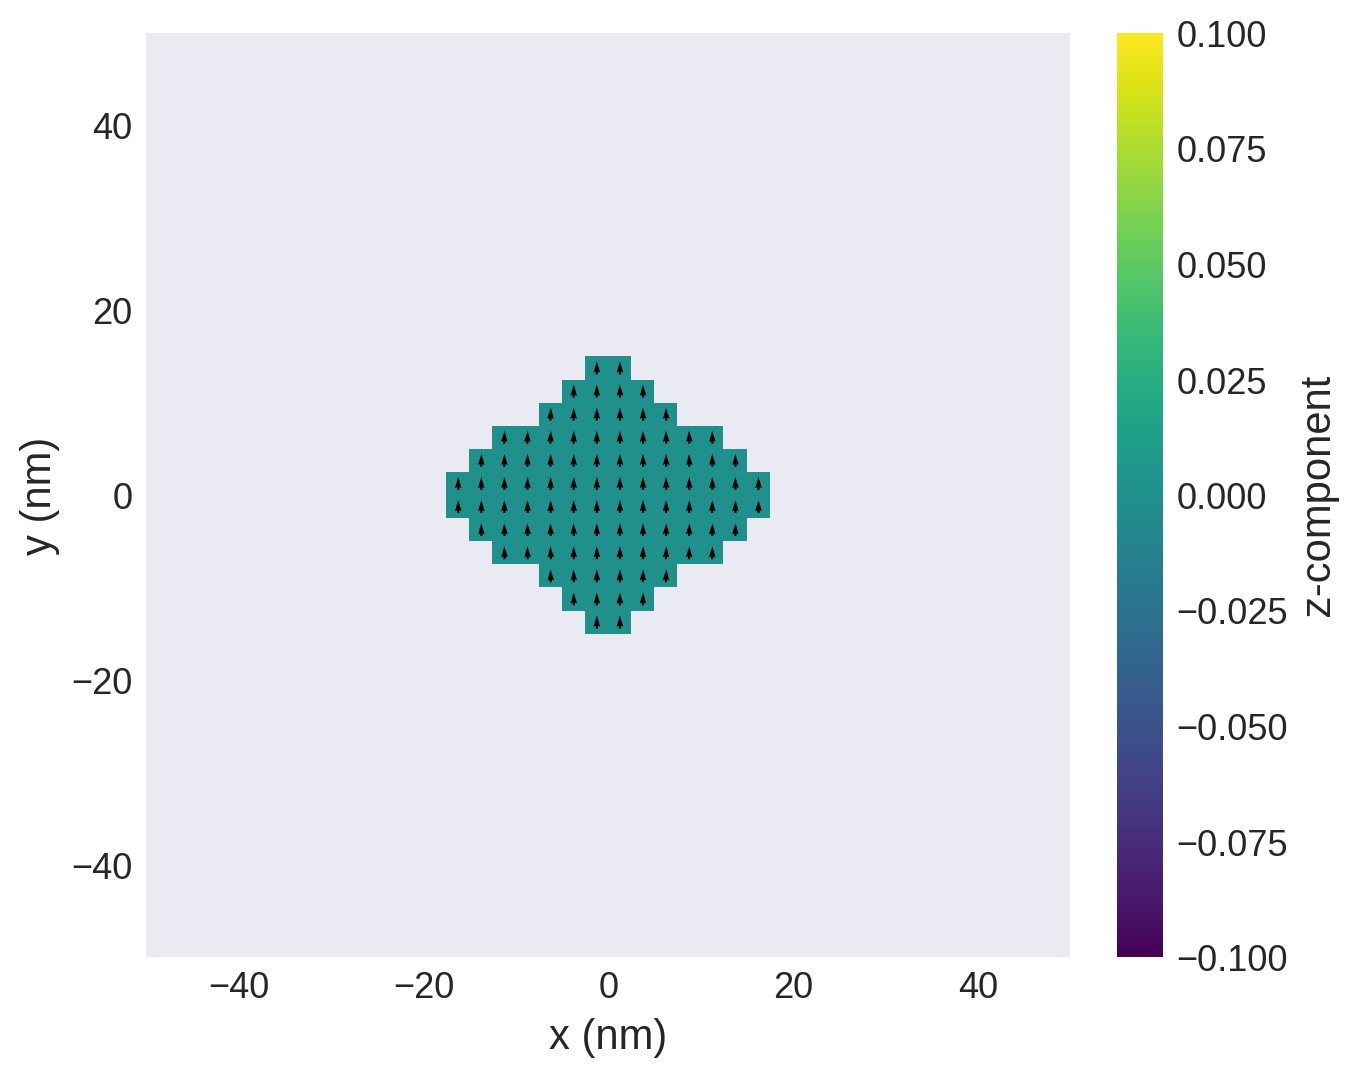

In [23]:
system.m.sel('z').mpl()

Lets start the optimization - first we wll define the bounds over which our optimizer can search.

In [24]:
pbounds = {'sx': (10e-9, np.sqrt(2)*100e-9), 'sy': (10e-9, np.sqrt(2)*100e-9)}

Initialize the optimizer.

In [25]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

Now lets maximize the objective function.

In [26]:
optimizer.maximize(
    init_points=5,
    n_iter=50,
)

|   iter    |  target   |    sx     |    sy     |
-------------------------------------------------
| 1         | 2.387e+03 | 6.481e-08 | 1.047e-07 |
| 2         | 2.387e+03 | 1.002e-08 | 4.973e-08 |
| 3         | 4.775e+04 | 2.929e-08 | 2.214e-08 |
| 4         | 2.387e+03 | 3.448e-08 | 5.541e-08 |
| 5         | 2.387e+03 | 6.214e-08 | 8.081e-08 |
| 6         | 2.387e+05 | 1.4e-07   | 1.178e-08 |
| 7         | 2.387e+05 | 1.407e-07 | 1.135e-08 |
| 8         | 2.387e+05 | 1.409e-07 | 1.057e-08 |
| 9         | 2.387e+05 | 1.41e-07  | 1.054e-08 |
| 10        | 2.387e+05 | 1.413e-07 | 1.121e-08 |
| 11        | 2.387e+05 | 1.405e-07 | 1.042e-08 |
| 12        | 2.387e+05 | 1.402e-07 | 1.105e-08 |
| 13        | 2.387e+05 | 1.412e-07 | 1.141e-08 |
| 14        | 2.387e+05 | 1.393e-07 | 1.098e-08 |
| 15        | 2.387e+05 | 1.403e-07 | 1.11e-08  |
| 16        | 2.387e+05 | 1.405e-07 | 1.008e-08 |
| 17        | 2.387e+05 | 1.401e-07 | 1.004e-08 |
| 18        | 2.387e+05 | 1.404e-07 | 1.051e-08 |


In [27]:
print(optimizer.max)

{'target': 238732.41437817164, 'params': {'sx': 1.3999415922779442e-07, 'sy': 1.1778197725767783e-08}}


Lets run the simulation again with the best values to check the simulation and the shape.

In [28]:
sx, sy = optimizer.max['params']['sx'], optimizer.max['params']['sy']
system.m = df.Field(mesh, nvdim=3, value=(0, 1, 0), norm=lambda p: in_diamond(p, sx, sy), valid="norm")  # Change shape
hd.drive(system, Hsteps=[[tuple(Hmax.value), Hmin, n]], verbose=0)  # Field sweep
H_y = me.H(system.table.data["By_hysteresis"].values*u.Unit(system.table.units["By_hysteresis"]).to(u.A/u.m))
M_y = system.table.data["my"].values*Ms
results_linear = mammos_analysis.hysteresis.find_linear_segment(H_y, M_y, margin=0.01*Ms, min_points=2)  # Find linear segment

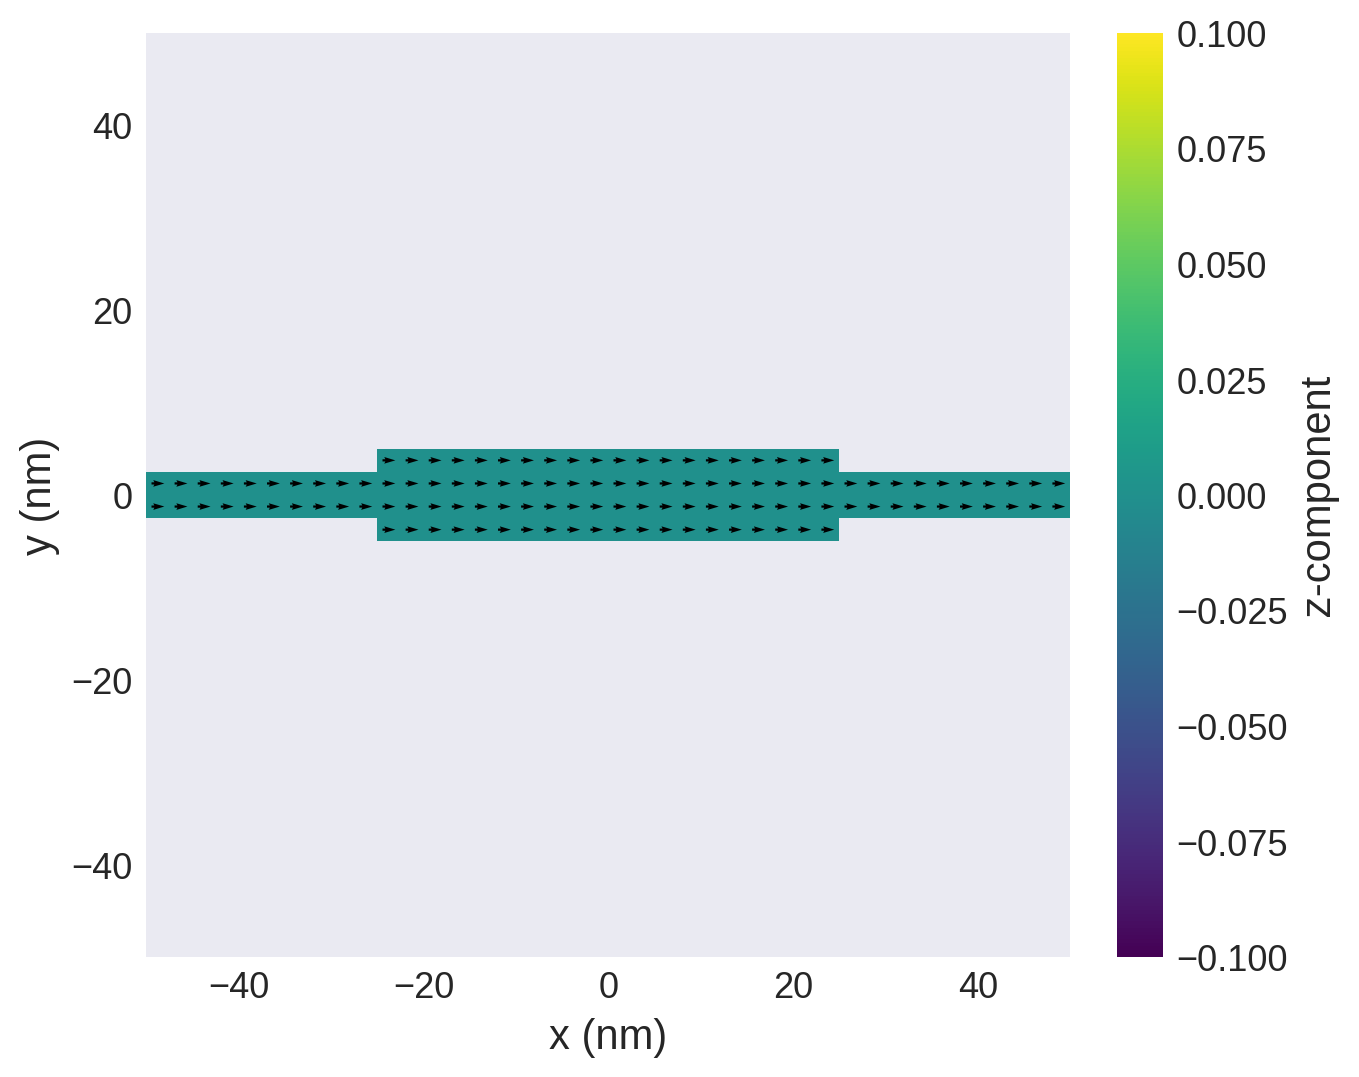

In [29]:
system.m.sel('z').mpl()

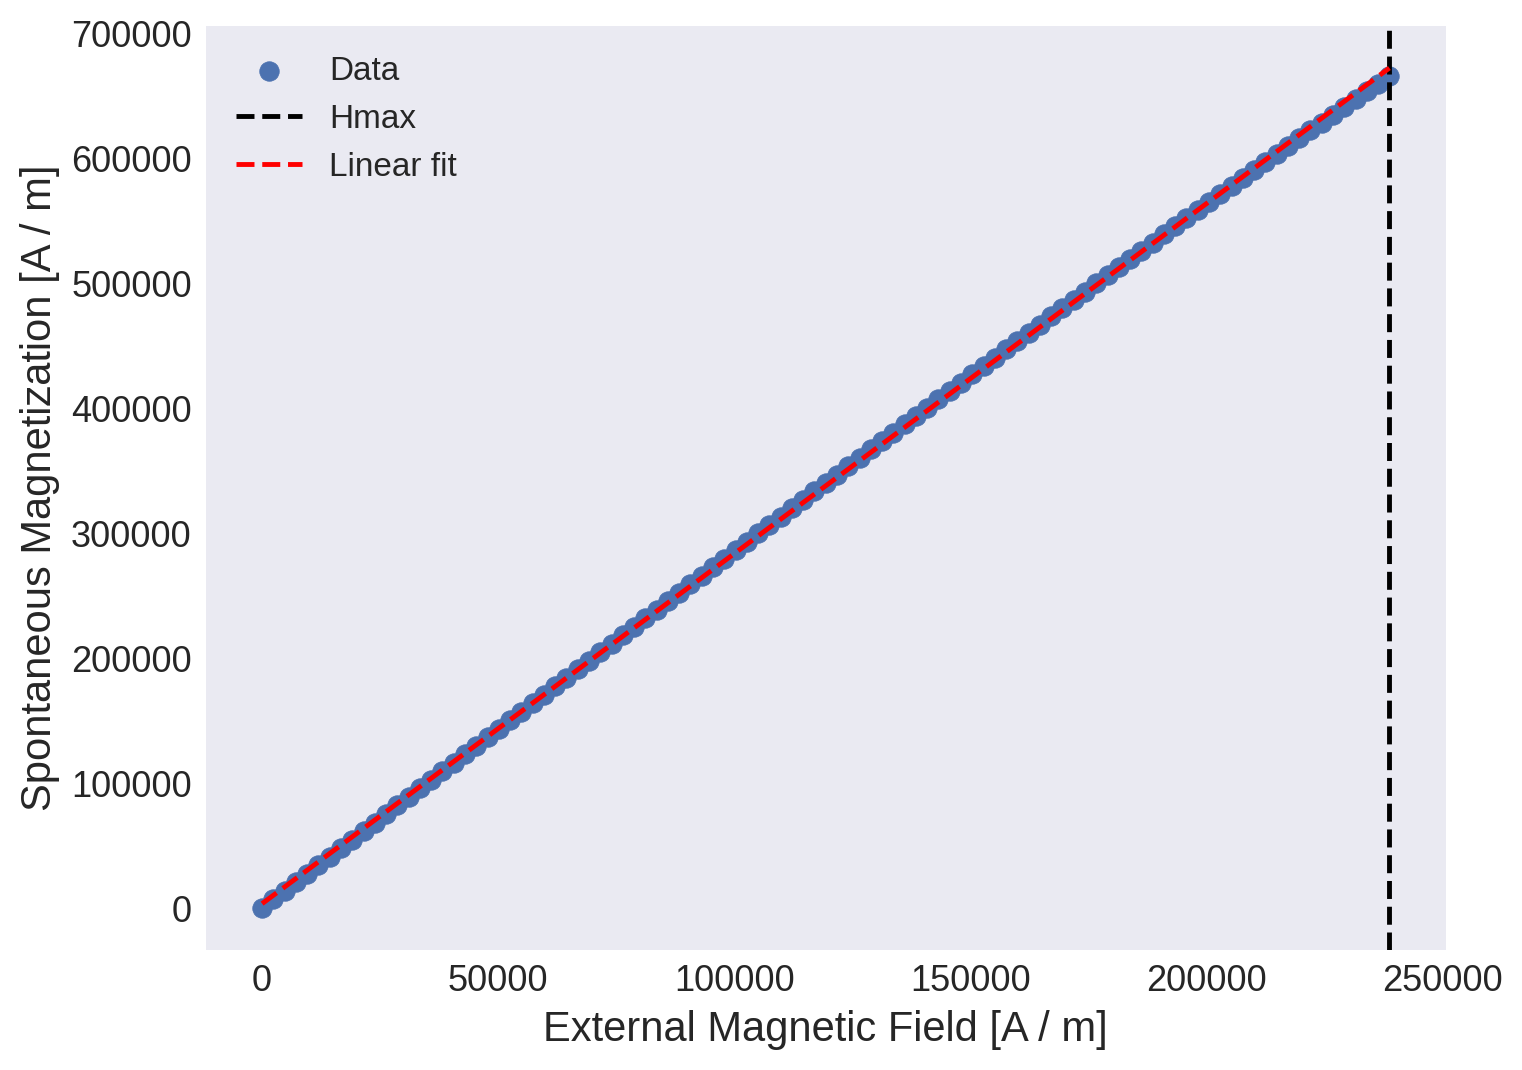

In [30]:
results_linear.plot();

We can also use the built in tools of `ubermag` to visualize the magnetization as a function of applied field directly. 

In [31]:
data = md.Data(system.name)

drive = data[-1]
drive = drive.register_callback(lambda x: x.sel('z'))  # TODO: Remove when new ubermag is released

drive.hv(kdims=['x', 'y'])

BokehModel(combine_events=True, render_bundle={'docs_json': {'043053da-cd03-4637-b942-61167ba69e47': {'version…